In [1]:
# External libs
import numpy as np
from pandas import DataFrame as df
import importlib

# My modules (must be in the same folder of main.ipynb)
import autoregressiveFunctions as ar
import statFunctions as stat

In [2]:
importlib.reload(ar) # if autoregressiveFunctions.py is modified 
importlib.reload(stat) # if statFunctions.py is modified 

<module 'statFunctions' from 'c:\\Users\\alber\\python_projects\\fundamentals_of_interest_rates\\statFunctions.py'>

# Autoregressive (AR) Processes

An autoregressive (AR) process is a type of time series model where the current value of the series depends linearly on its past values and a random shock (innovation). 

#### General AR(p)
A general AR(p) process depends on the last \(p\) lags:

$$
y_t = a_0 + a_1 y_{t-1} + a_2 y_{t-2} + \dots + a_p y_{t-p} + \varepsilon_t
$$

- The order \(p\) indicates how many past values influence the current value. 

- $a_0$ is a constant term  
- $a_1$ is an autoregressive coefficient  
- $\varepsilon_t$ is a white noise error term





In [49]:
a = np.array([0.1, -0.5, 0.3, 0.4, -0.2])
p = a.size -1

data = ar.generate_ar(steps=100_000, paths=9, a=a, start=0, dist='normal', error_var=1)

100%|██████████| 99996/99996 [00:00<00:00, 228995.69it/s]

9 different AR(4) processes of 99998 steps have been generated with increments following normal distribution


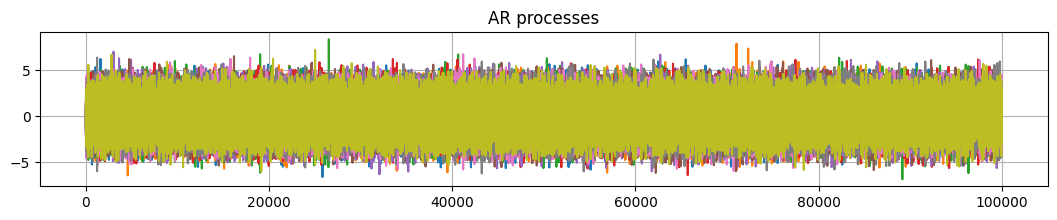

In [50]:
ar.plot_paths(data, size=(13,2))

### Stationarity

In general, an AR(p) is stationary if the roots of the characteristic polynomial lie outside the unit circle.

For an autoregressive process AR(p), the characteristic polynomial is defined as:

$$
\phi(z) = 1 - a_1 z - a_2 z^2 - \dots - a_p z^p
$$

So, it is stationary if:

$$
|z_i| > 1 \quad \forall i
$$

This condition ensures that the effect of past shocks decays over time and the process does not diverge.

As a consequence, we have that:

1. The **mean** is constant:

$$
\mathbb{E}[y_t] = \frac{a_0}{1 - a_1 - \dots - a_p}
$$

2. The **variance** is finite and constant (this formula is for AR(1) only, for p>1 we need to solve Yule-Walker system):

$$
\mathrm{Var}(y_t) = \frac{\sigma^2}{1 - a_1^2}
$$

3. The **autocovariance** depends only on the lag \(k\):

$$
\gamma_k = \mathrm{Cov}(y_t, y_{t-k})
$$

Let's check this facts empirically

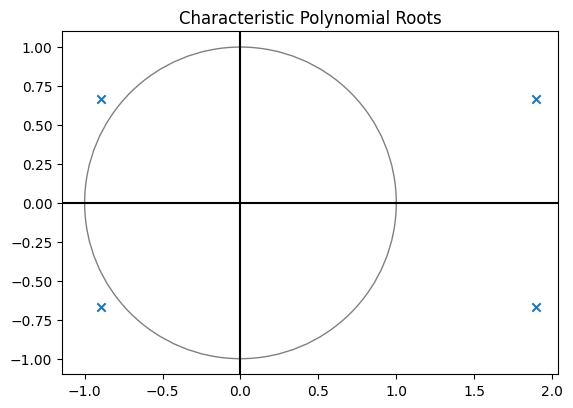

The process is stationary!


In [51]:
roots = ar.characteristic_poly_roots(a, show_plot=True)

if np.all((np.absolute(roots)) > 1):
    print('The process is stationary!')
else:
    print('The process is not stationary')

First of all let's generate many simulations with an increasing # of steps, this will be usefull for the next analysis in order to evaluate empirically the convergence.


((((((Qustion: is it okay, when generating multiple paths in the same simulation, to take the mean before for axis0 and then axis1?))))))

In [52]:
steps_list = [100, 1_000, 10_000, 100_000, 1_000_000]

simulations = ar.iterate_simulations(steps_list, paths=1, a=a, error_var=1)

Now let's check if increasing the # of steps we see a convergence of the sample mean toward the theoretical mean

In [53]:
theoretic_mean = (a[0]/(1 - np.sum(a[1:])))
sample_means = [np.mean(sim, axis=0).mean() for sim in simulations.values()]

print(df({'steps': steps_list,'sample_mean': sample_means}))
print(f'The theoretic mean is {theoretic_mean:6f}')


     steps  sample_mean
0      100     0.028918
1     1000     0.069320
2    10000     0.089499
3   100000     0.095749
4  1000000     0.100096
The theoretic mean is 0.100000


Okay we actually see a convergence. Let's see what happens for the variance. For this we have to simulate an AR(1):

In [59]:
sigma_2 = 1
simulations_ar1 = ar.iterate_simulations(steps_list, paths=1, a=np.array([0.3, 0.6]), error_var=sigma_2)

In [60]:
theoretic_variance = (sigma_2 / (1 - np.sum(a[1]**2)))  # This is an approxmation since for p > 1 we 
sample_vars = [np.var(sim, axis=0).mean() for sim in simulations_ar1.values()]

print(df({'steps': steps_list,'sample_variance': sample_vars}))
print(f'The theoretic variance is {theoretic_variance:6f}')

     steps  sample_variance
0      100         1.000275
1     1000         1.641471
2    10000         1.591333
3   100000         1.573538
4  1000000         1.561690
The theoretic variance is 1.333333


In [61]:
theoretic_variance = (sigma_2 / (1 - a[1]**2)) * (2 * a[1] * a[0]) / (1 - a[1])    # This is an approxmation since for p > 1 we 
sample_vars = [np.var(sim, axis=0).mean() for sim in simulations_ar1.values()]

print(df({'steps': steps_list,'sample_variance': sample_vars}))
print(f'The theoretic variance is {theoretic_variance:6f}')

     steps  sample_variance
0      100         1.000275
1     1000         1.641471
2    10000         1.591333
3   100000         1.573538
4  1000000         1.561690
The theoretic variance is -0.088889


### Fitting an AR(p) Model using OLS

We assume a time series that follows an AR(p) process:

$$
y_t = a_0 + a_1 y_{t-1} + \dots + a_p y_{t-p} + \varepsilon_t
$$

---

#### Matrix Representation

Let:

- \(Y\) = vector of observed values starting from lag \(p\):

$$
Y =
\begin{bmatrix}
y_p \\
y_{p+1} \\
\vdots \\
y_T
\end{bmatrix}
$$

- \(X\) = design matrix of lagged values:

$$
X =
\begin{bmatrix}
1 & y_{p-1} & y_{p-2} & \dots & y_{0} \\
1 & y_{p} & y_{p-1} & \dots & y_{1} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & y_{T-1} & y_{T-2} & \dots & y_{T-p}
\end{bmatrix}
$$

Then the AR(p) model is:

$$
Y = Xa + \varepsilon
$$

where:

$$
a =
\begin{bmatrix}
a_0 \\
a_1 \\
\vdots \\
a_p
\end{bmatrix}
$$

---

#### OLS Estimator

The OLS solution (least squares estimator) is:

$$
\hat{a} = (X^\top X)^{-1} X^\top Y
$$


In [57]:
coefficients = ar.fit_ar_ols(data, p=p)
df(np.vstack([np.mean(coefficients, axis=1),a]).T).rename(columns={0: 'avg fitted coefficient', 1:'real coefficient'})


,avg fitted coefficient,real coefficient
0,0.099430,0.1
1,-0.502074,-0.5
2,0.299086,0.3
3,0.400655,0.4
4,-0.198653,-0.2


Now let's do some test on residuals

In [43]:
std_residuals = ar.get_residuals(data = data, coefficients = coefficients, p=p, std_residuals = True)

100%|██████████| 99996/99996 [00:00<00:00, 179659.25it/s]


In [44]:
stat.compute_moments(std_residuals)

,0,1,2,3,4,5,6,7,8
mean,-0.000042,-0.000010,-0.000025,0.000051,0.000017,0.000035,-0.000025,-0.000073,-0.000021
variance,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
skewness,-0.013376,0.002871,0.005684,-0.012733,0.012043,-0.000689,0.000663,-0.003059,0.005431
kurtosis,3.018216,2.997165,3.002508,3.017250,3.007190,2.999119,2.995031,3.001706,3.014634


In [45]:
stat.jb_test(std_residuals)

,0,1,2,3,4,5,6,7,8
jb stat,4.364524,0.170823,0.564741,3.942031,2.632446,0.011151,0.110223,0.168066,1.383843
p value,0.112786,0.918134,0.753994,0.139315,0.268146,0.994440,0.946380,0.919401,0.500613


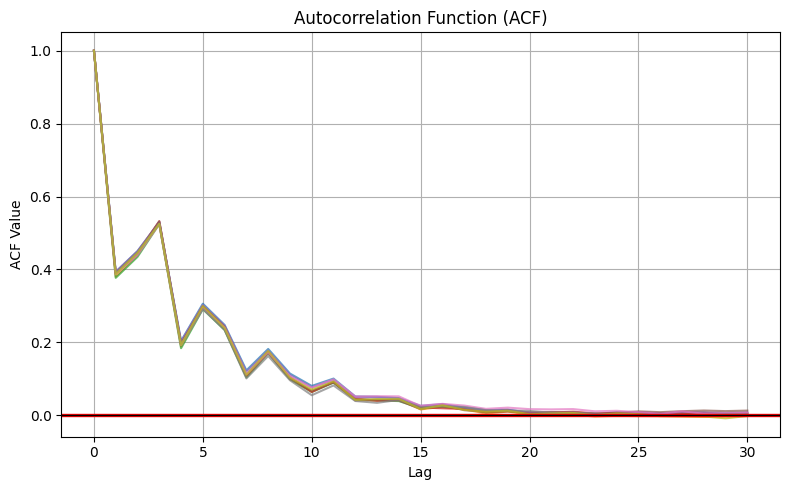

In [46]:
acf_summary = stat.auto_correlation_function(std_residuals, p=30)
stat.plot_acf(acf_summary, steps=data.shape[0])

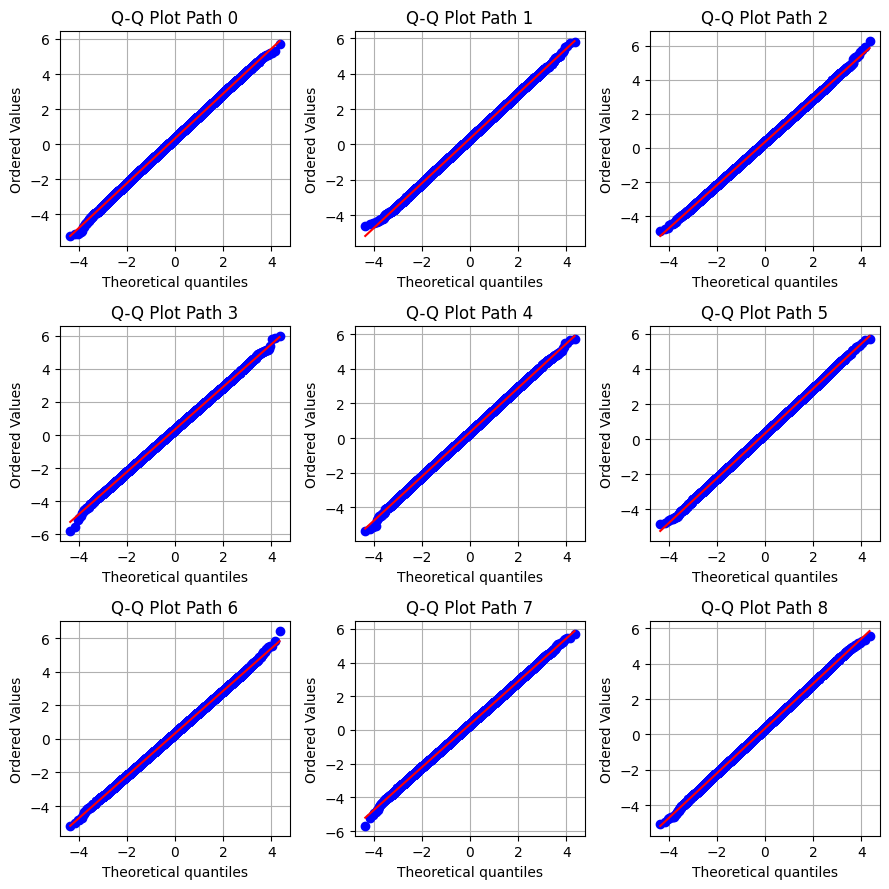

In [15]:
stat.qq_plot(data, dist='normal', ncols=3) 